In [1]:
import socceraction
import socceraction.atomic.spadl as atomicspadl

In [2]:
import matplotlib
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import urllib
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import RegularPolygon
from mplsoccer import Pitch, VerticalPitch, lines
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [3]:
fe = fm.FontEntry(
    fname='/Users/davidegualano/Documents/Python FTBLData/SourceSansPro-Regular.ttf',
    name='SourceSansPro-Regular'
)
fm.fontManager.ttflist.insert(0, fe)
matplotlib.rcParams['font.family'] = fe.name

In [4]:
fb = pd.read_csv("teamsFOTMOB.csv", index_col = 0)

players0 = pd.read_csv("players2021.csv", index_col = 0)
players1 = pd.read_csv("players2122.csv", index_col = 0)
players2 = pd.read_csv("players2223.csv", index_col = 0)
players3 = pd.read_csv("players2324.csv", index_col = 0)

games0 = pd.read_csv("games2021.csv", index_col = 0)
games1 = pd.read_csv("games2122.csv", index_col = 0)
games2 = pd.read_csv("games2223.csv", index_col = 0)
games3 = pd.read_csv("games2324.csv", index_col = 0)

actions0 = pd.read_csv("atomic_actions2021.csv", index_col = 0)
actions1 = pd.read_csv("atomic_actions2122.csv", index_col = 0)
actions2 = pd.read_csv("atomic_actions2223.csv", index_col = 0)
actions3 = pd.read_csv("atomic_actions2324.csv", index_col = 0)

In [5]:
players = pd.concat([players0, players1, players2, players3])
games = pd.concat([games0, games1, games2, games3])
actions = pd.concat([actions0, actions1, actions2, actions3])

In [6]:
actions.drop(columns=['action_id'], inplace=True)
actions.reset_index(drop=True, inplace=True)
actions.reset_index(inplace=True)
actions.rename(columns={'index': 'action_id'}, inplace=True)

In [7]:
def convert_to_seconds(time_str):
    try:
        # Convert to string in case it's a float (e.g., NaN)
        time_str = str(time_str)
        # Split the time string into minutes and seconds
        minutes, seconds = map(int, time_str.split(':'))
        # Convert total time to seconds (minutes converted to seconds)
        return minutes * 60 + seconds
    except (ValueError, AttributeError):
        # Handle cases where the conversion fails (e.g., NaN or bad format)
        return 0  # or use `np.nan` if you prefer to mark as missing

# Apply the conversion function to the 'minutes_played' column
players['seconds_played'] = players['minutes_played'].apply(convert_to_seconds)
players['start_second'] = players['start_second'].apply(convert_to_seconds)
players['end_second'] = players['end_second'].apply(convert_to_seconds)

In [8]:
atomic = atomicspadl.add_names(actions)

In [9]:
df0 = atomic.merge(players, on=['game_id', 'team_id', 'player_id'])

In [10]:
df = df0.merge(fb)

In [11]:
def format_season_id(season_id):
    # Convert to integer if it's a float
    season_id = int(season_id)
    # Extract the last two digits of the year
    start_year = str(season_id -1)[-2:]
    # Calculate the end year
    end_year = str(season_id)[-2:]
    # Format as 20/21
    formatted_season = f"{start_year}/{end_year}"
    return formatted_season

In [12]:
df.type_name.unique()

array(['pass', 'receival', 'dribble', 'interception', 'out', 'throw_in',
       'clearance', 'take_on', 'tackle', 'corner', 'shot', 'offside',
       'freekick', 'bad_touch', 'keeper_pick_up', 'foul', 'keeper_save',
       'cross', 'goalkick', 'keeper_claim', 'goal', 'keeper_punch',
       'shot_penalty', 'owngoal'], dtype=object)

In [13]:
df1 = df[df["type_name"].isin(['pass', 'receival', 'dribble', 'interception', 'out', 'clearance', 'take_on', 'tackle', 'shot', 'offside',
                              'bad_touch', 'keeper_pick_up', 'foul', 'keeper_save', 'cross', 'goalkick', 'keeper_claim', 'goal', 
                               'keeper_punch',  'owngoal'])]

In [14]:
teamlist = df['team_name'].unique().tolist()
cleaned_teamlist = [name for name in teamlist  if pd.notna(name)]
cleaned_teamlist.sort()

In [15]:
from IPython.display import display, HTML

# Step 3: Generate the HTML dropdown
options_html = ''.join([f'<option value="{name}">{name}</option>' for name in cleaned_teamlist])

dropdown_html = f"""
<input list="players" id="dropdown" oninput="handleInput()" placeholder="Choose Someone">
<datalist id="players">
    {options_html}
</datalist>
<p id="output"></p>
<script>
function handleInput() {{
    var input = document.getElementById("dropdown").value;
    var output = document.getElementById("output");
    output.innerHTML = "Selected: " + input;
}}
</script>
"""

# Display the dropdown
display(HTML(dropdown_html))

In [16]:
df2a = df1[df1["team_name"] == "AC Milan"]
df2a.season_id.unique()

array([2021, 2122, 2223, 2324])

In [17]:
# Apply the function to the 'season_id' column
df2a['formatted_season'] = df2a['season_id'].apply(format_season_id)
df2b = df2a[df2a["season_id"].isin([2324.])]

/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_1175/2270656556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2a['formatted_season'] = df2a['season_id'].apply(format_season_id)


In [18]:
df3a = df2b[df2b["game_id"].isin(df2b.game_id.unique())]

In [19]:
df3a.player_name.unique()

array(['Olivier Giroud', 'Ruben Loftus-Cheek', 'Tijjani Reijnders',
       'Fikayo Tomori', 'Davide Calabria', 'Théo Hernández',
       'Mike Maignan', 'Christian Pulisic', 'Alessandro Florenzi',
       'Rafael Leão', 'Yunus Musah', 'Tommaso Pobega', 'Luka Jovic',
       'Noah Okafor', 'Samuel Chukwueze', 'Davide Bartesaghi',
       'Malick Thiaw', 'Rade Krunic', 'Pierre Kalulu', 'Yacine Adli',
       'Simon Kjær', 'Chaka Traorè', 'Marco Sportiello', 'Matteo Gabbia',
       'Ismaël Bennacer', 'Filippo Terracciano', 'Luka Romero',
       'Jan-Carlo Simic', 'Álex Jiménez', 'Francesco Camarda',
       'Antonio Mirante', 'Kevin Zeroli', 'Mattia Caldara', 'Lapo Nava',
       'Marco Pellegrino'], dtype=object)

In [24]:
df3 = df3a[df3a["player_name"] == 'Olivier Giroud']

In [25]:
# Initialize an empty list to store results
results = []

# Loop through each unique game_id in df2b
for game_id in df2b['game_id'].unique():
    # Filter df3 for the current game_id
    game_data = df3[df3['game_id'] == game_id]

    if not game_data.empty:
        # Extract the necessary variables for the first row of the game_data
        start_second = game_data['start_second'].iloc[0]
        end_second = game_data['end_second'].iloc[0]
        start_period = game_data['start_period'].iloc[0]
        end_period = game_data['end_period'].iloc[0]
        
        # Filter df3a for the relevant start and end rows
        start_row = df3a[(df3a['period_id'] == start_period) & (df3a['time_seconds'] >= start_second)].head(1)
        end_row = df3a[(df3a['period_id'] == end_period) & (df3a['time_seconds'] <= end_second)].tail(1)
        
        if not start_row.empty and not end_row.empty:
            start_idx = start_row.index[0]
            end_idx = end_row.index[0]
            
            if start_idx <= end_idx:
                # Filter all rows between the identified start and end rows, inclusive
                df4 = df3a.loc[start_idx:end_idx]
                
                # Optionally add a column for game_id to keep track of which game this data belongs to
                df4['game_id'] = game_id
                
                # Append the filtered DataFrame to results
                results.append(df4)

# Concatenate all results into a single DataFrame if needed
df4 = pd.concat(results, ignore_index=True)


/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_1175/3666525652.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['game_id'] = game_id


/var/folders/ns/3wxdg4g57h77vxwmr4wzmvt40000gn/T/ipykernel_1175/2246656825.py:22: RuntimeWarning: invalid value encountered in divide
  normalized_statistic = np.where(bin_statisticplayer['statistic'] != 0, bin_statisticplayer['statistic'] / bin_statisticteam['statistic'], 0)


(-0.5, 191.5, 191.5, -0.5)

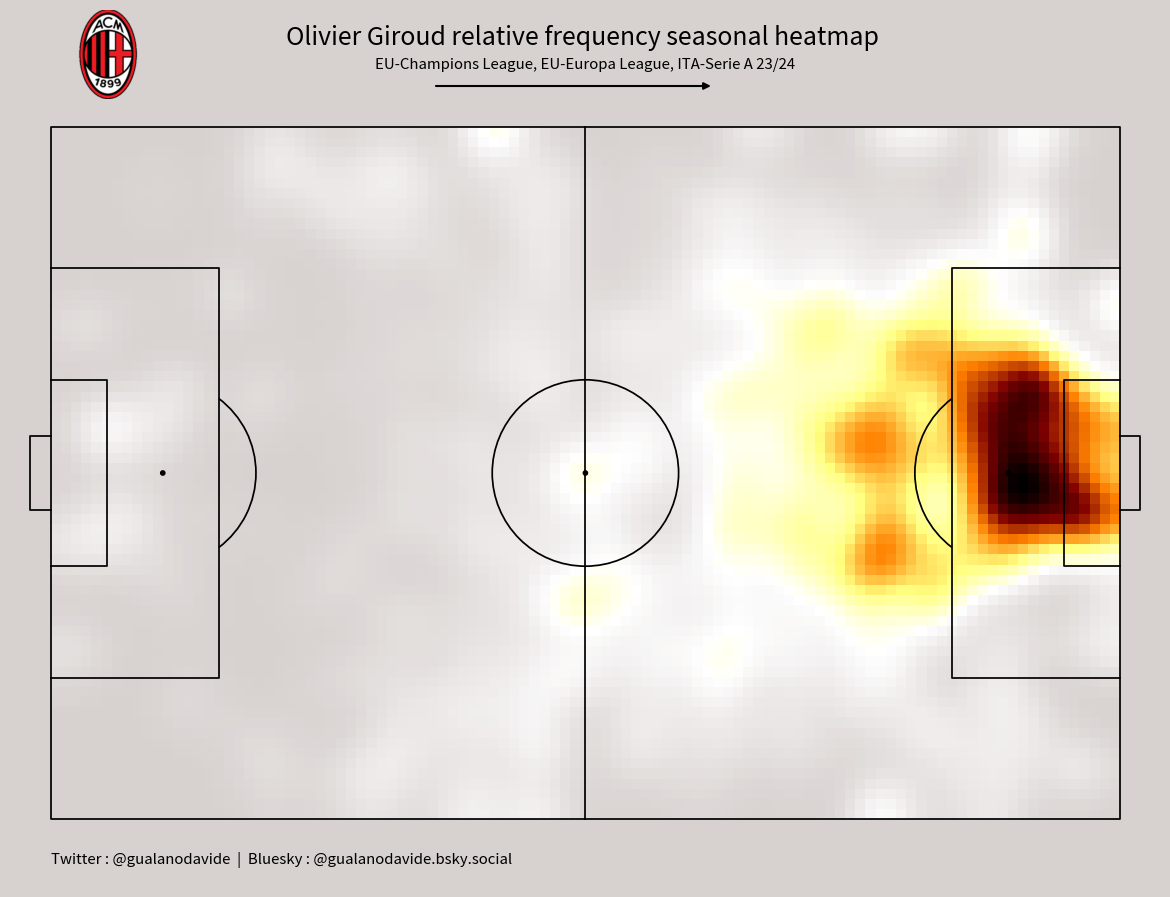

In [47]:
nrows = df3.shape[0]
for y in range(nrows):
    title = df3['team_name'].iloc[y]
    title1 = df3['player_name'].iloc[y]
    title2 = df3['season_id'].iloc[y]

pitch = Pitch(pitch_type='custom', pitch_width=68, pitch_length=105, goal_type='box', linewidth=1.25, line_color='#000000', 
              line_zorder=2, pitch_color='#D7D1CF')

fig, axs = pitch.grid(endnote_height=0.03, endnote_space=0, grid_width=0.88, left=0.025, title_height=0.06, title_space=0, axis=False,
                      grid_height=0.86)

fig.set_facecolor('#D7D1CF')

# Define the colormap with #D7D1CF as the lowest value
cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#D7D1CF', '#FFFFFF', '#FFFF80', '#FF8000', '#800000', '#000000'], N=256)

bin_statisticplayer = pitch.bin_statistic(df3.x_a0, df3.y_a0, statistic='count', bins=(105, 68))
bin_statisticteam = pitch.bin_statistic(df4.x_a0, df4.y_a0, statistic='count', bins=(105, 68))

# Normalize bin_statistic['statistic'] using bin_statistic2['statistic']
normalized_statistic = np.where(bin_statisticplayer['statistic'] != 0, bin_statisticplayer['statistic'] / bin_statisticteam['statistic'], 0)

# Apply Gaussian smoothing
bin_statisticplayer['statistic'] = gaussian_filter(normalized_statistic, 2.5)
pcm = pitch.heatmap(bin_statisticplayer, ax=axs['pitch'], cmap=cmap)

# endnote and title
axs['endnote'].text(0, 1, 'Twitter : @gualanodavide  |  Bluesky : @gualanodavide.bsky.social', va='center', ha='left', fontsize=12, color='#000000')
ax_title = axs['title'].text(0.5, .9, f"{title1} relative frequency seasonal heatmap ", color='#000000', va='center', ha='center',
                             fontsize=20)
ax_title = axs['title'].text(0.5, .4, f"{', '.join(df3['competition_id'].unique())} {', '.join(df3['formatted_season'].unique())}", color='#000000', va='center', ha='center',
                             fontsize=12)

# Annotation with data coordinates and offset points.
title5 = axs['title'].annotate(xy=(.62, 0), xytext=(-200, 0), textcoords="offset points", text="",
    size=10, color="#000000", arrowprops=dict(arrowstyle="-|>", shrinkA=0, color="black", linewidth=1.5))

# Club logo and annotations
fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{df3['fotmob_id'].iloc[0]}.png"))

# Add the club logos to the subplot 1
logo_ax1 = fig.add_axes([0.05, 0.9, 0.1, 0.1], zorder=1)  # Adjusted to fit subplot 1
logo_ax1.imshow(club_icon)
logo_ax1.axis("off")
